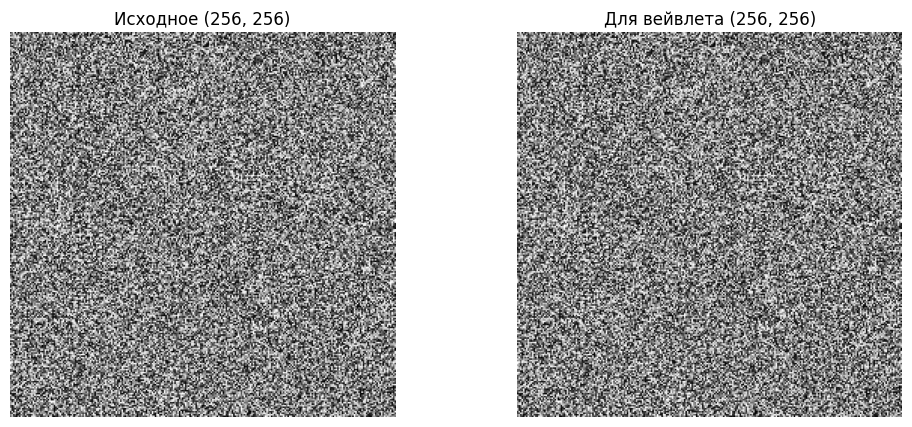

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline


image = cv2.imread(r'C:\Users\engfile\image_processing\dz6\image.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:

    image = np.random.randint(0, 256, (256, 256), dtype=np.uint8)

def resize_to_power_of_two(img):
    h, w = img.shape
    new_h = 2 ** int(np.log2(h))
    new_w = 2 ** int(np.log2(w))
    return cv2.resize(img, (new_w, new_h))

image_resized = resize_to_power_of_two(image)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f'Исходное {image.shape}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_resized, cmap='gray')
plt.title(f'Для вейвлета {image_resized.shape}')
plt.axis('off')
plt.show()

image = image_resized  

In [ ]:
print("=== ЗАДАНИЕ 1: Сохранение монохромного изображения ===")


np.savetxt('image_text.txt', image, fmt='%d')
print("✓ Сохранено в текстовый файл: image_text.txt")

image.tofile('image_binary.bin')
print("✓ Сохранено в бинарный файл: image_binary.bin")

text_size = os.path.getsize('image_text.txt')
binary_size = os.path.getsize('image_binary.bin')
original_size = image.nbytes

print(f"Размер исходного массива: {original_size} байт")
print(f"Размер текстового файла: {text_size} байт")
print(f"Размер бинарного файла: {binary_size} байт")
print(f"Коэффициент сжатия (текст): {text_size/original_size:.2f}")
print(f"Коэффициент сжатия (бинарный): {binary_size/original_size:.2f}")

=== ЗАДАНИЕ 1: Сохранение монохромного изображения ===
✓ Сохранено в текстовый файл: image_text.txt
✓ Сохранено в бинарный файл: image_binary.bin
Размер исходного массива: 65536 байт
Размер текстового файла: 234275 байт
Размер бинарного файла: 65536 байт
Коэффициент сжатия (текст): 3.57
Коэффициент сжатия (бинарный): 1.00



=== ЗАДАНИЕ 2: Вейвлет-преобразование Хаара ===


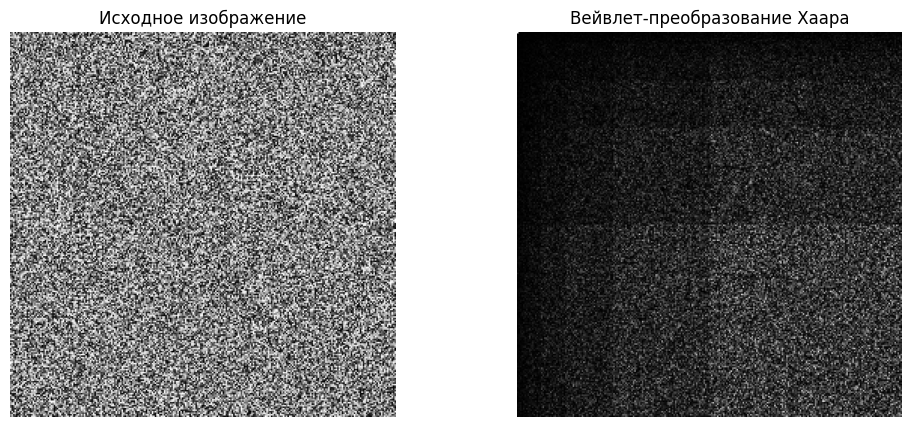

✓ Вейвлет-преобразование выполнено


In [ ]:
print("\n=== ЗАДАНИЕ 2: Вейвлет-преобразование Хаара ===")

def haar_wavelet_transform(img):
    """Одномерное преобразование Хаара"""
    n = len(img)
    if n <= 1:
        return img
    

    avg = (img[0::2] + img[1::2]) / 2
    diff = (img[0::2] - img[1::2]) / 2
    

    return np.concatenate([haar_wavelet_transform(avg), diff])

def haar_2d_transform(img):
    """Двумерное преобразование Хаара"""
    h, w = img.shape
    

    row_transform = np.zeros_like(img, dtype=float)
    for i in range(h):
        row_transform[i] = haar_wavelet_transform(img[i].astype(float))
    result = np.zeros_like(img, dtype=float)
    for j in range(w):
        result[:, j] = haar_wavelet_transform(row_transform[:, j])
    
    return result


haar_result = haar_2d_transform(image)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.abs(haar_result), cmap='gray')
plt.title('Вейвлет-преобразование Хаара')
plt.axis('off')
plt.show()

print("✓ Вейвлет-преобразование выполнено")


=== ЗАДАНИЕ 3: Квантование высокочастотных компонент ===


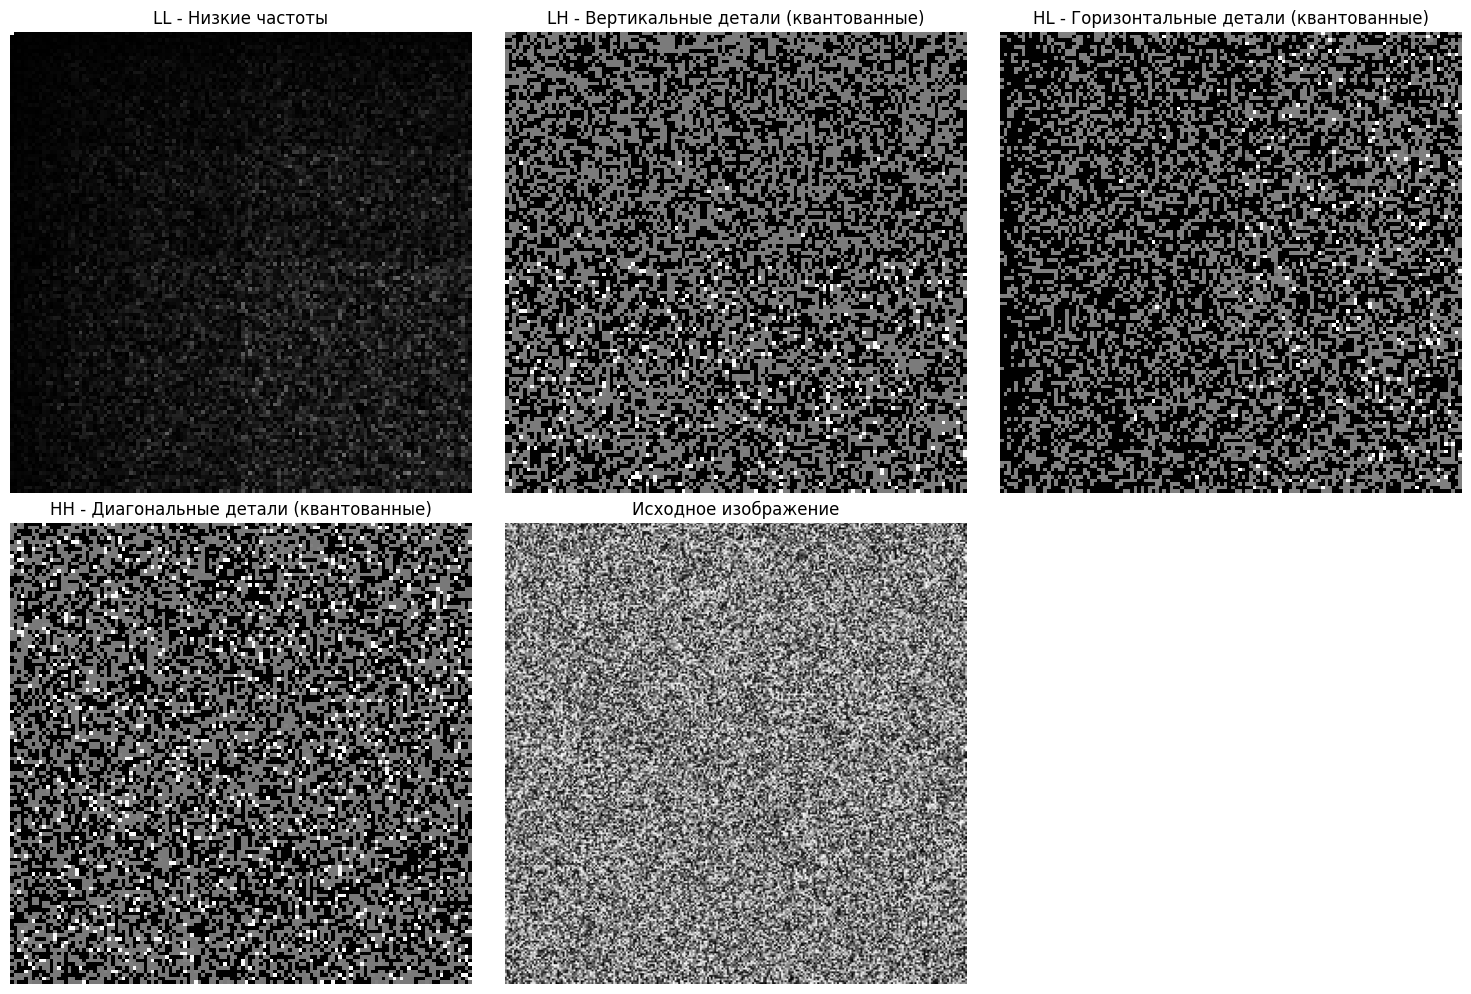

✓ Квантование выполнено (4 уровня)


In [ ]:
print("\n=== ЗАДАНИЕ 3: Квантование высокочастотных компонент ===")

def quantize_high_frequency(haar_coeffs, num_quants=4):
    """Квантование высокочастотных компонент"""
    h, w = haar_coeffs.shape
    h2, w2 = h//2, w//2
    

    LL = haar_coeffs[:h2, :w2]          # Низкие частоты
    LH = haar_coeffs[:h2, w2:]          # Вертикальные детали
    HL = haar_coeffs[h2:, :w2]          # Горизонтальные детали  
    HH = haar_coeffs[h2:, w2:]          # Диагональные детали

    def quantize_subband(subband, levels):
        min_val, max_val = np.min(subband), np.max(subband)
        if min_val == max_val:
            return subband
        
        step = (max_val - min_val) / levels
        quantized = np.floor((subband - min_val) / step) * step + min_val
        return quantized
    
    LH_quant = quantize_subband(LH, num_quants)
    HL_quant = quantize_subband(HL, num_quants) 
    HH_quant = quantize_subband(HH, num_quants)
    
    return LL, LH_quant, HL_quant, HH_quant


LL, LH, HL, HH = quantize_high_frequency(haar_result, num_quants=4)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(np.abs(LL), cmap='gray')
plt.title('LL - Низкие частоты')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.abs(LH), cmap='gray')
plt.title('LH - Вертикальные детали (квантованные)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.abs(HL), cmap='gray')
plt.title('HL - Горизонтальные детали (квантованные)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.abs(HH), cmap='gray')
plt.title('HH - Диагональные детали (квантованные)')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
print("\n=== ЗАДАНИЕ 4: Сжатие длин серий и сохранение ===")

def run_length_encode(data):
    """Сжатие длин серий (RLE)"""
    if len(data) == 0:
        return []
    
    encoded = []
    current_val = data[0]
    count = 1
    
    for i in range(1, len(data)):
        if data[i] == current_val:
            count += 1
        else:
            encoded.append((current_val, count))
            current_val = data[i]
            count = 1
    
    encoded.append((current_val, count))
    return encoded

LH_rle = run_length_encode(LH.flatten())
HL_rle = run_length_encode(HL.flatten()) 
HH_rle = run_length_encode(HH.flatten())

print(f"LH: {len(LH.flatten())} -> {len(LH_rle)} пар")
print(f"HL: {len(HL.flatten())} -> {len(HL_rle)} пар") 
print(f"HH: {len(HH.flatten())} -> {len(HH_rle)} пар")


with open('wavelet_compressed.txt', 'w') as f:

    f.write("LL_component:\n")
    np.savetxt(f, LL, fmt='%.6f')

    f.write("\nLH_component_RLE:\n")
    for val, count in LH_rle:
        f.write(f"{val:.6f} {count}\n")
        
    f.write("\nHL_component_RLE:\n")
    for val, count in HL_rle:
        f.write(f"{val:.6f} {count}\n")
        
    f.write("\nHH_component_RLE:\n")
    for val, count in HH_rle:
        f.write(f"{val:.6f} {count}\n")

print("✓ Данные сохранены в wavelet_compressed.txt")


=== ЗАДАНИЕ 4: Сжатие длин серий и сохранение ===
LH: 16384 -> 8832 пар
HL: 16384 -> 8649 пар
HH: 16384 -> 9864 пар
✓ Данные сохранены в wavelet_compressed.txt



=== СРАВНЕНИЕ ОБЪЕМОВ ПАМЯТИ ===


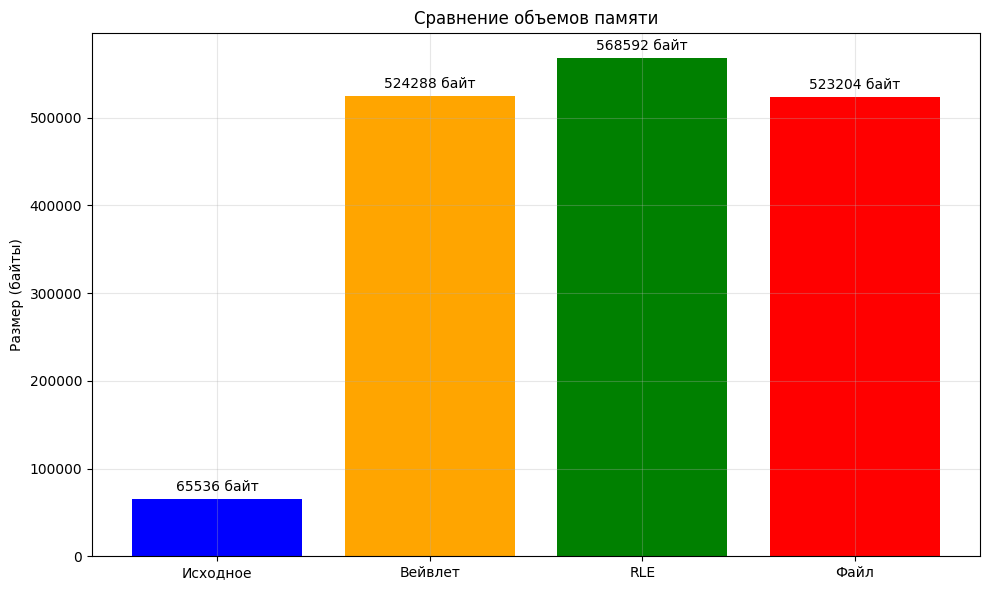

In [18]:
print("\n=== СРАВНЕНИЕ ОБЪЕМОВ ПАМЯТИ ===")


original_size = image.nbytes


haar_size = haar_result.nbytes

LL_size = LL.nbytes
LH_rle_size = len(LH_rle) * 8 * 2 
HL_rle_size = len(HL_rle) * 8 * 2
HH_rle_size = len(HH_rle) * 8 * 2
compressed_total = LL_size + LH_rle_size + HL_rle_size + HH_rle_size

file_size = os.path.getsize('wavelet_compressed.txt')



sizes = [original_size, haar_size, compressed_total, file_size]
labels = ['Исходное', 'Вейвлет', 'RLE', 'Файл']

plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=['blue', 'orange', 'green', 'red'])
plt.ylabel('Размер (байты)')
plt.title('Сравнение объемов памяти')
plt.grid(True, alpha=0.3)

for i, v in enumerate(sizes):
    plt.text(i, v + max(sizes)*0.01, f'{v} байт', ha='center', va='bottom')

plt.tight_layout()
plt.show()